In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import contractions


from time import time
import numpy as np
import pandas as pd
import tensorflow as tf

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3

# TF IDF Imports


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

In [2]:
df = pd.read_csv('./datasets/test_filtered_data.csv')

In [3]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 25      # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(df)
test_portion=.025

In [4]:
comments = df['comment_text']
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
# y_binary = df['isToxic']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(comments, y, test_size=test_portion)

In [6]:
tokenizer = Tokenizer(
    # num_words=500,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    oov_token=oov_tok,
)

In [7]:
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)


In [8]:
sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [9]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [11]:
input_dimension = vocab_size + 1

model = Sequential()
model.add(Embedding(input_dim=input_dimension, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(64))
model.add(Dense(6, activation='sigmoid')) 


2024-02-26 18:46:10.794918: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-26 18:46:10.794946: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-26 18:46:10.794950: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-26 18:46:10.794989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-26 18:46:10.795003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [13]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


class_weights = dict(enumerate(sample_weights))

history = model.fit(
    padded_sequences, 
    y_train, 
    epochs=15, 
    validation_data=(test_padded_sequences, y_test),
    class_weight=class_weights,
    batch_size=64
)
print("Training Complete")

Epoch 1/15


2024-02-26 18:46:11.517972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


229/229 [==============================] - 7s 27ms/step - loss: 0.0039 - accuracy: 0.8735 - val_loss: 0.1493 - val_accuracy: 0.9947
Epoch 2/15
229/229 [==============================] - 4s 20ms/step - loss: 0.0031 - accuracy: 0.7892 - val_loss: 0.1498 - val_accuracy: 0.9947
Epoch 3/15
229/229 [==============================] - 4s 19ms/step - loss: 0.0031 - accuracy: 0.6706 - val_loss: 0.1336 - val_accuracy: 0.7307
Epoch 4/15
229/229 [==============================] - 4s 18ms/step - loss: 0.0023 - accuracy: 0.7204 - val_loss: 0.0845 - val_accuracy: 0.0720
Epoch 5/15
229/229 [==============================] - 4s 18ms/step - loss: 0.0016 - accuracy: 0.8401 - val_loss: 0.0802 - val_accuracy: 0.1280
Epoch 6/15
229/229 [==============================] - 4s 19ms/step - loss: 0.0012 - accuracy: 0.7637 - val_loss: 0.0740 - val_accuracy: 0.9733
Epoch 7/15
229/229 [==============================] - 4s 18ms/step - loss: 9.7729e-04 - accuracy: 0.9543 - val_loss: 0.0713 - val_accuracy: 0.9573
Epoch 

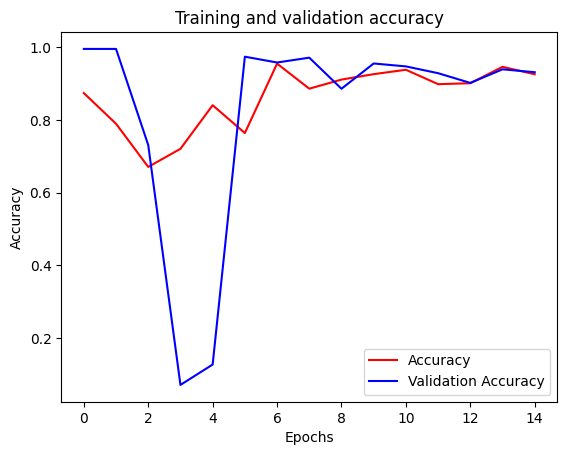

<Figure size 640x480 with 0 Axes>

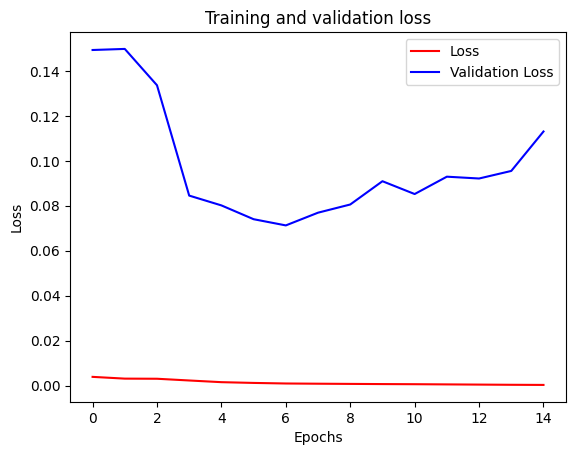

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [15]:
def get_indices_above_threshold(pred, threshold=0.5):
    indices = [index for index, value in enumerate(pred) if value > threshold]
    return indices

In [16]:
i = 0

In [20]:
ph = df[df['isToxic'] == 1].iloc[i]

phrase = [ph['comment_text']]
print(phrase)

tokenizer.fit_on_texts(phrase)
sequences_phrase = tokenizer.texts_to_sequences(phrase)
print(sequences_phrase)
padded_sequences_phrase = pad_sequences(sequences_phrase, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(model.predict(padded_sequences_phrase))
i += 1

print(ph)


['poop pee toot fart gas diareah zoey poop she stinks want marry baby call stop deleting this']
[[3216, 9476, 18468, 11109, 3253, 18469, 18470, 3216, 760, 8999, 37, 8283, 2209, 360, 85, 496, 19]]
1/1 [==============================] - 0s 14ms/step
[[0.7043774  0.00639479 0.10227437 0.03093655 0.10850668 0.04751027]]
Unnamed: 0                                                   60782
id                                                a2b4567e40d34e72
comment_text     poop pee toot fart gas diareah zoey poop she s...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           1
identity_hate                                                    0
isToxic                                                          1
Name: 14, dt

In [18]:
# Inverser le dictionnaire de mots
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

# Récupérer le mot pour l'ID 1
word = reverse_word_index.get(1)
print(word)

<OOV>
